In [17]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [18]:
df = pd.read_excel('data/mergedDataSerieA.xlsx')
df.tail()

,Date,Div,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AwayLosses,UltimoScontroDiretto,Last3PointsDifference,GoalRatioDifference,EwmaGoalsSum,GoalsSum,HomePointGap,AwayPointGap,HomeGoalGap,AwayGoalGap
1895,2024-05-26,I1,19:45:00,Empoli,Roma,2,1,H,1,1,...,1.0,A,3.0,-0.945111,4.146760,188,-30,30,-37,37
1896,2024-05-26,I1,19:45:00,Frosinone,Udinese,0,1,A,0,0,...,2.0,D,0.0,-0.032186,5.644400,201,1,-1,8,-8
1897,2024-05-26,I1,19:45:00,Lazio,Sassuolo,1,1,D,0,0,...,1.0,H,8.0,0.695590,5.779803,202,31,-31,6,-6
1898,2024-05-26,I1,19:45:00,Verona,Inter,2,2,D,2,2,...,1.0,A,0.0,-3.615306,6.224400,192,-56,56,-51,51
1899,2024-06-02,I1,17:00:00,Atalanta,Fiorentina,2,3,A,2,3,...,0.0,A,3.0,0.476690,6.578318,211,12,-12,12,-12


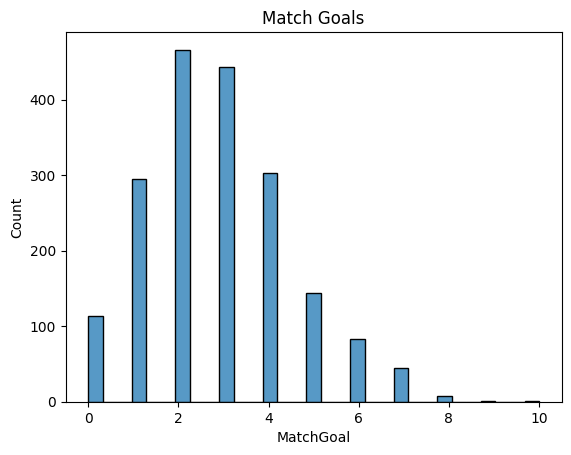

In [19]:
# Data distribution
plt.title('Match Goals')
sns.histplot(df['MatchGoal'])
plt.show()

In [20]:
df['EloDifference'] = abs(df['elo_home'] - df['elo_away'])

In [21]:
df['feat1'] = abs((df['HomeEwmaGoalsScored'] + df['HomeEwmaGoalsConceded']) / (df['AwayEwmaGoalsScored'] + df['AwayEwmaGoalsConceded']))
df['feat2'] = abs((df['HomeGoalsCumulative'] + df['AwayGoalsCumulative']) / (df['HomeGoalsConcededCumulative'] + df['AwayGoalsConcededCumulative']))

df['feat2'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['feat1'].replace([np.inf, -np.inf], np.nan, inplace=True)

columns_to_check = [
    'feat1'
    , 'feat2'
]
df['GoalCumulativeSum'] = df['HomeGoalsCumulative']	+ df['AwayGoalsCumulative']
df['GoalCumulativeSumPrev'] = df['GoalCumulativeSum'].shift(1)

df = df[df['GoalCumulativeSum'] > 10]

# # df = df.dropna(subset=columns_to_check)

C:\Users\vitto\AppData\Local\Temp\ipykernel_14288\3661288815.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['feat2'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\vitto\AppData\Local\Temp\ipykernel_14288\3661288815.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

In [22]:
features = [
      # 'feat2',
        'feat1',
        # 'GoalCumulativeSum'
]

df['isOver'] = np.where(df['MatchGoal'] > 2.5, 1, 0)
x_train, x_test, y_train, y_test = train_test_split(df[features], df['isOver'], test_size= 0.3, random_state= 42,shuffle=True)

x_train = x_train.sort_index()
x_test = x_test.sort_index()
y_train= y_train.sort_index()
y_test = y_test.sort_index()


print (f'X_train: {x_train.shape} \nX_test: {x_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}')

X_train: (1173, 1) 
X_test: (504, 1) 
y_train: (1173,) 
y_test: (504,)


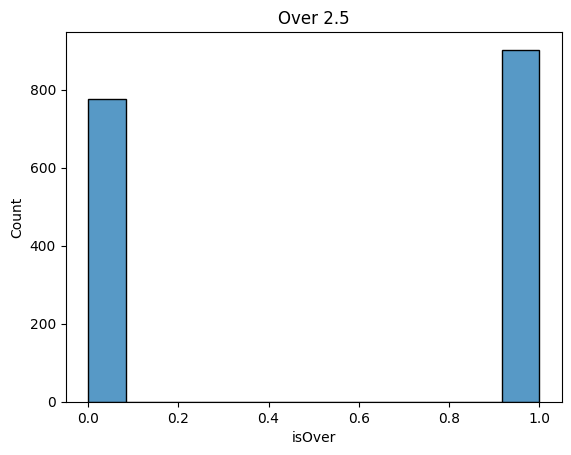

In [23]:
plt.title('Over 2.5')
sns.histplot(df['isOver'])
plt.show()

In [24]:
# Regressor model
from sklearn.tree import DecisionTreeClassifier 
# Crea e addestra il modello di albero di decisione per la regressione
model = DecisionTreeClassifier(random_state=42
                                , min_samples_split=80
                                # , class_weight={1: 1.2, 0: 1}
                                # , class_weight='balanced'
                                , max_depth=3  # , ccp_alpha= 0.00001
                                # , max_features= 3
                                ).fit(x_train, y_train)

In [25]:
# Prediction result
y_pred_test = model.predict(x_test)     # predicted value of y_test
y_pred_train = model.predict(x_train)   # predicted value of y_train

df_test = df[df.index.isin(x_test.index)]

df_test['prediction'] = y_pred_test

from sklearn.metrics import accuracy_score
print(f"Accuracy score: {round(100*accuracy_score(y_test, df_test['prediction']),2)}%")


Accuracy score: 54.76%


C:\Users\vitto\AppData\Local\Temp\ipykernel_14288\3017391250.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['prediction'] = y_pred_test


In [26]:
from sklearn import metrics

mae = metrics.mean_absolute_error(y_test, y_pred_test)
mse = metrics.mean_squared_error(y_test, y_pred_test)
r2 = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))

print('Mean Absolute Error:', mae)
print('Mean Square Error:', mse)
print('Root Mean Square Error:', r2)

Mean Absolute Error: 0.4523809523809524
Mean Square Error: 0.4523809523809524
Root Mean Square Error: 0.6725927091345493


In [27]:
quotaMin = 1.50
def calculate_gain_O25(row):
    
    if (row['prediction'] == 1):
        if row['B365>2.5'] > quotaMin :
            if row['MatchGoal'] > 2.5:
                return row['B365>2.5']+0.1-1
            else:
                return -1
        else:
            return 0
    elif (row['prediction'] == 0): 
        if row['B365<2.5'] > quotaMin :
            if row['MatchGoal'] < 2.5:
                return row['B365<2.5']+0.1-1
            else:
                return -1
        else:
            return 0
    else:
        return 0

def calculate_gain_Over25(row):
    if (row['prediction'] == 1):
        # return 0
        if row['B365>2.5'] > quotaMin :
            if row['MatchGoal'] > 2.5:
                return row['B365>2.5']-1
            else:
                return -1
        else:
            return 0
    else:
        return 0
    
def calculate_gain_Under25(row):
    if (row['prediction'] == 0): 
        # return 0
        if row['B365<2.5'] > quotaMin :
            if row['MatchGoal'] < 2.5:
                return row['B365<2.5']-1
            else:
                return -1
        else:
            return 0
    else:
        return 0

In [28]:
pred_prob = model.predict_proba(x_test.sort_index())
df2 = pd.DataFrame(pred_prob)
df2.index = df_test.index
df_test = df_test.merge(df2, left_index=True, right_index=True)

df_test['MyOverProb'] = df_test[1]
df_test['MyUnderProb'] = df_test[0]

df_test['Gain'] = df_test.apply(calculate_gain_O25, axis=1)
df_test['GainOver'] = df_test.apply(calculate_gain_Over25, axis=1)
df_test['GainUnder'] = df_test.apply(calculate_gain_Under25, axis=1)
df_test['Equity'] = df_test['Gain'].cumsum()
df_test['EquityOver'] = df_test['GainOver'].cumsum()
df_test['EquityUnder'] = df_test['GainUnder'].cumsum()
df_test['BookOverProb'] = 100/df_test['B365>2.5']
df_test['BookUnderProb'] = 100/df_test['B365<2.5']



print(df_test['Equity'].tail(1))
print(df_test['EquityOver'].tail(1))
print(df_test['EquityUnder'].tail(1))
df_test.to_excel('predicted.xlsx')

1891    40.06
Name: Equity, dtype: float64
1891    1.39
Name: EquityOver, dtype: float64
1891    13.17
Name: EquityUnder, dtype: float64


[0 1]


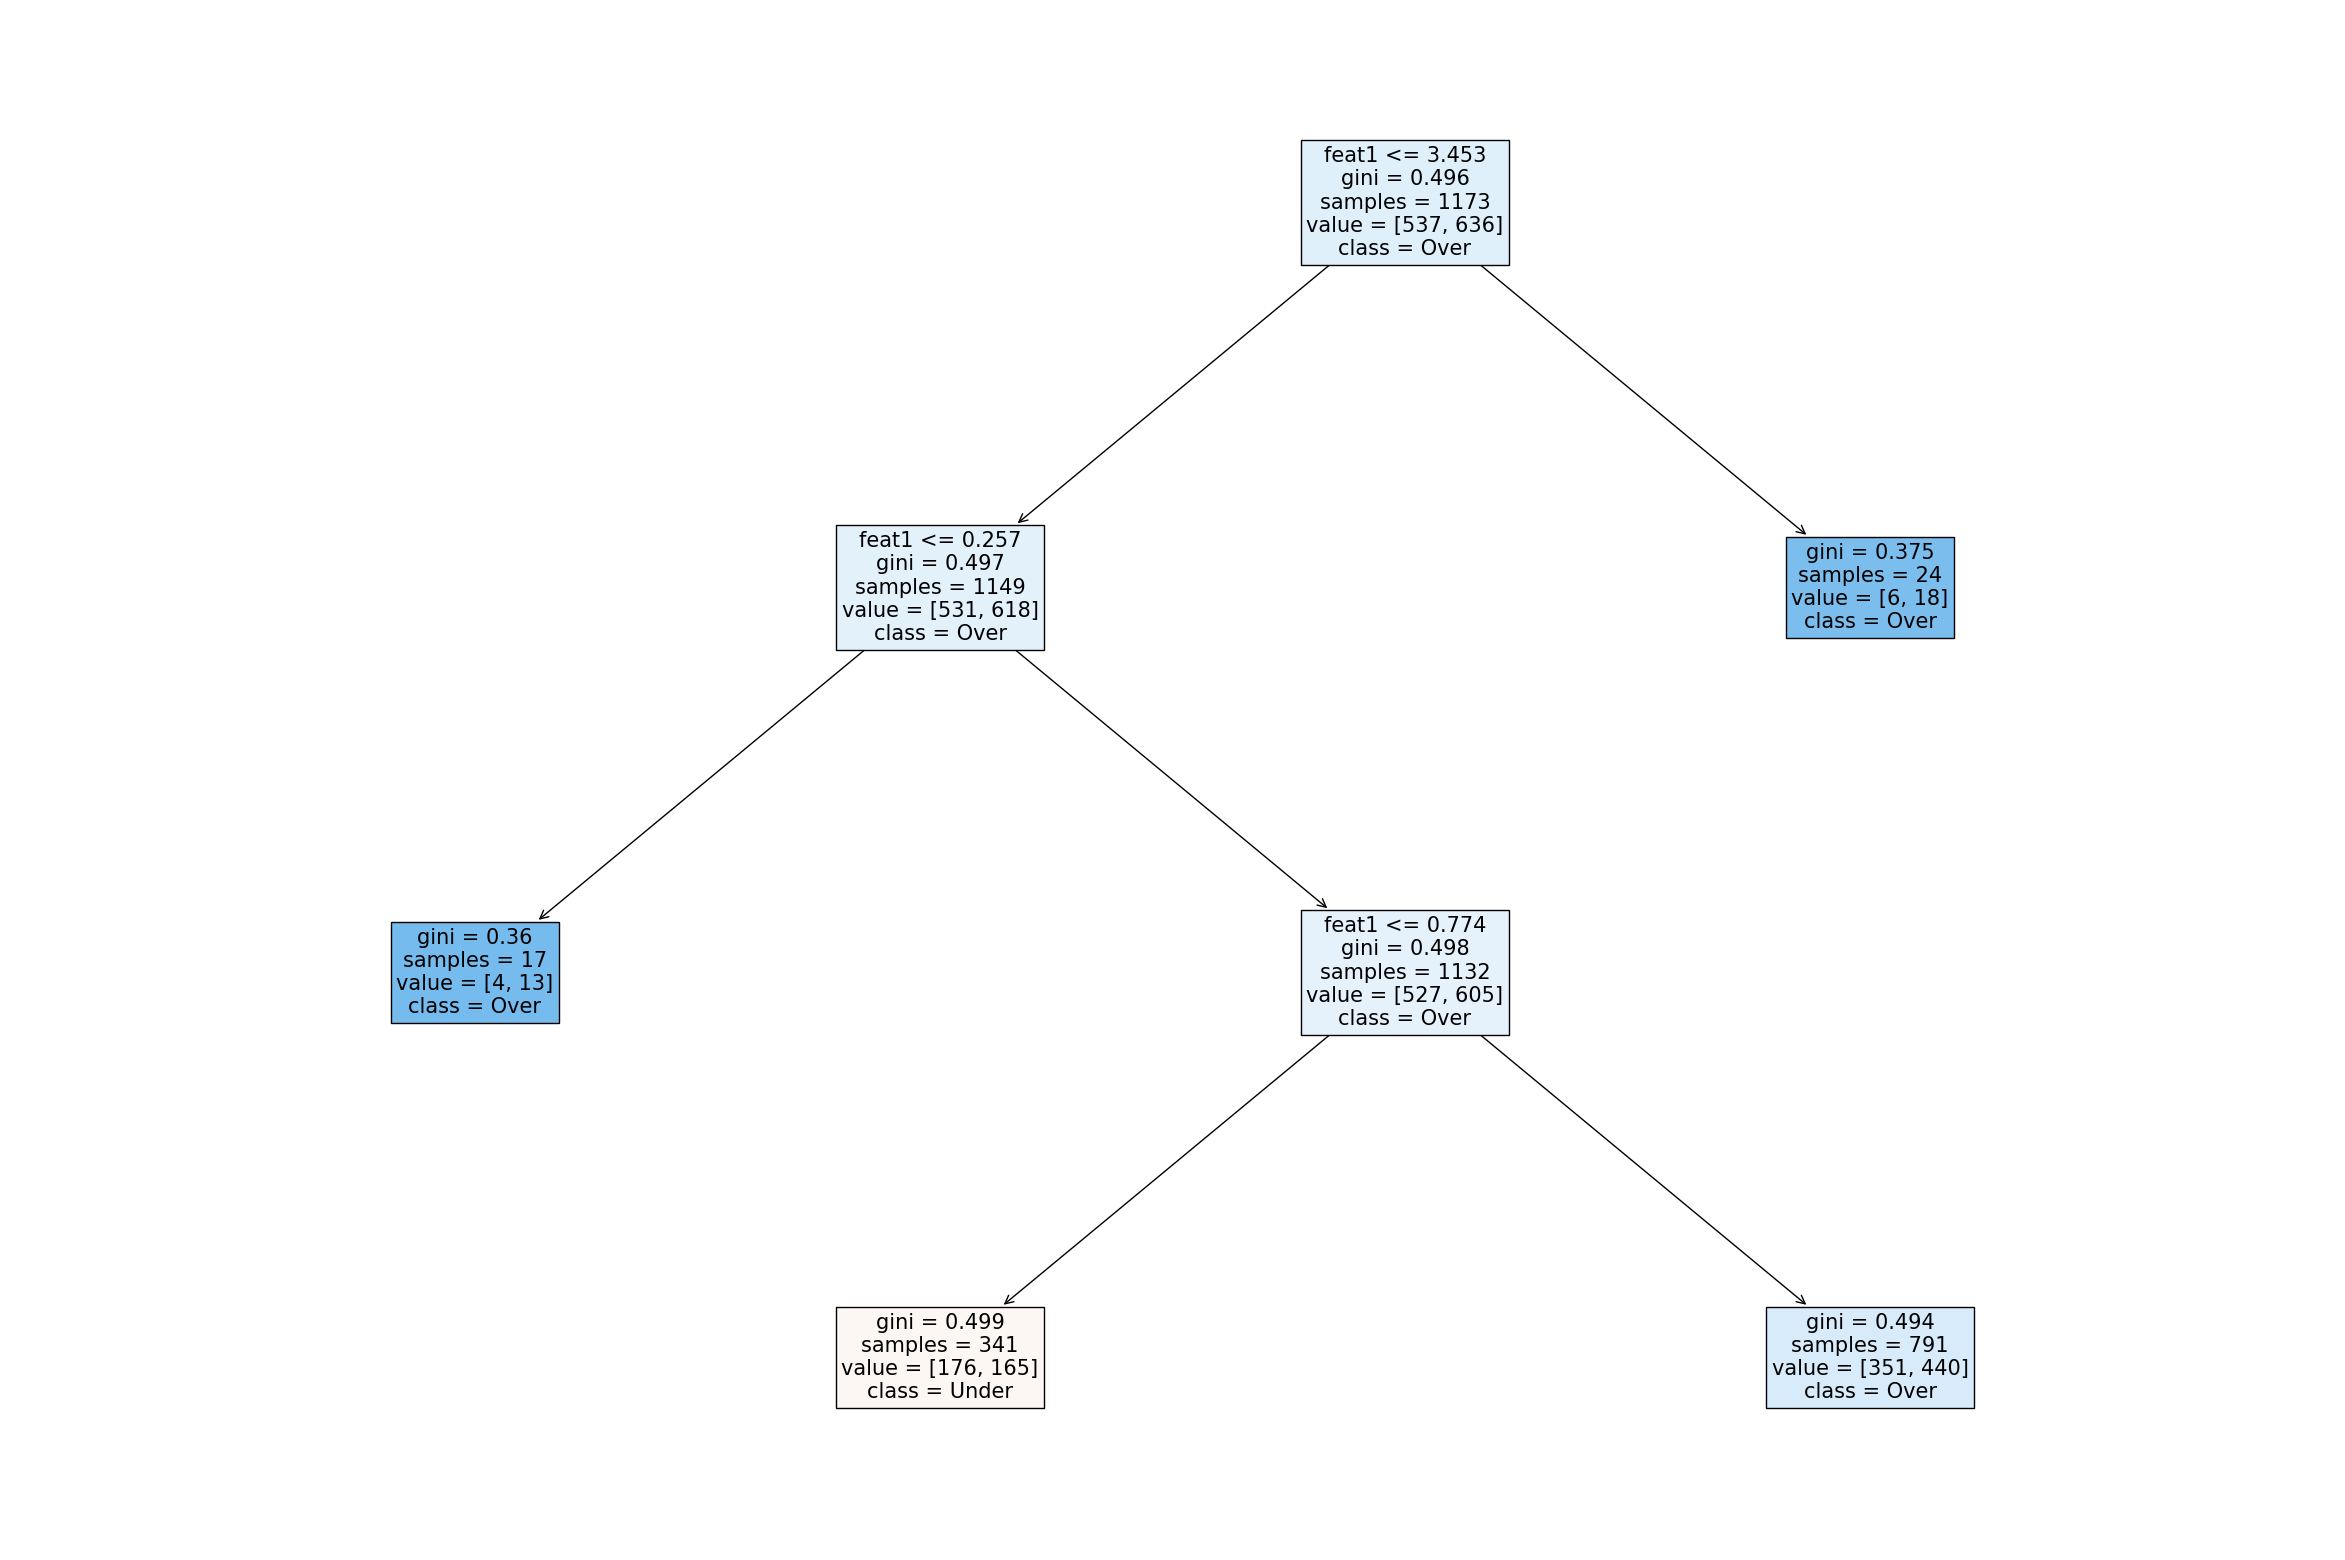

In [29]:
from sklearn import tree
plt.figure(figsize=(30, 20))

class_mapping = {
    0: "Under",
    1: "Over"
}
print(model.classes_)
tree.plot_tree(model, feature_names=features, filled=True, fontsize=15               # ,proportion=True  # Mostra la proporzione delle classi
               , class_names=pd.Series(model.classes_).map(class_mapping) #['Away', 'Home',  'Draw']
               )
plt.show()

In [30]:
from sklearn.metrics import classification_report
# Ottieni il rapporto di classificazione
report = classification_report(y_test, df_test['prediction'], output_dict=True)
print(report)
# Stampa l'accuratezza per ciascuna classe
for class_name, metrics in report.items():
    if class_name.isdigit():  # Verifica che si tratti di una classe e non di un aggregato (es. accuracy globale)
        print(f"Classe {class_name}: Precision = {metrics['precision']:.2f}")

{'0': {'precision': 0.5333333333333333, 'recall': 0.33613445378151263, 'f1-score': 0.41237113402061853, 'support': 238.0}, '1': {'precision': 0.5536723163841808, 'recall': 0.7368421052631579, 'f1-score': 0.632258064516129, 'support': 266.0}, 'accuracy': 0.5476190476190477, 'macro avg': {'precision': 0.543502824858757, 'recall': 0.5364882795223352, 'f1-score': 0.5223145992683738, 'support': 504.0}, 'weighted avg': {'precision': 0.5440677966101696, 'recall': 0.5476190476190477, 'f1-score': 0.5284225695599157, 'support': 504.0}}
Classe 0: Precision = 0.53
Classe 1: Precision = 0.55


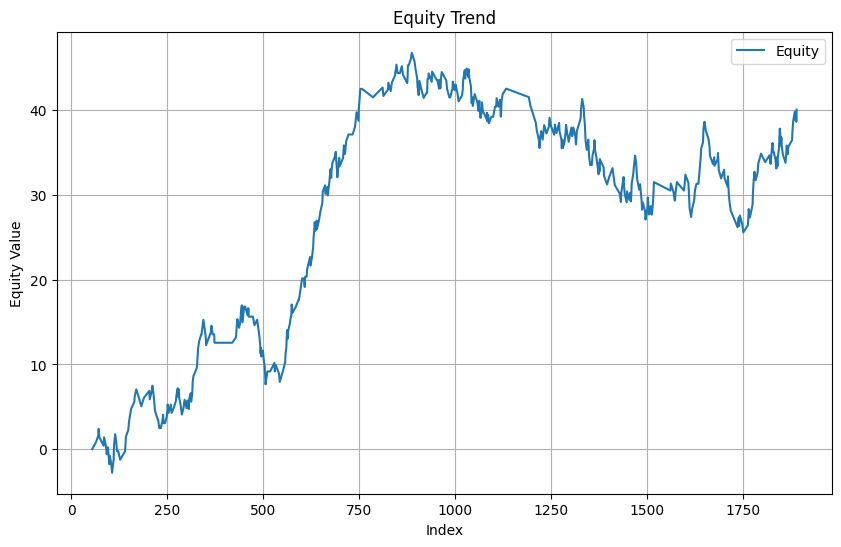

In [31]:
import matplotlib.pyplot as plt

# Supponiamo che il tuo dataframe si chiami 'df'
# Se il dataframe contiene una colonna chiamata 'equity'
plt.figure(figsize=(10,6))
plt.plot(df_test['Equity'], label='Equity')

# Impostiamo titolo e label
plt.title('Equity Trend')
plt.xlabel('Index')
plt.ylabel('Equity Value')

# Aggiungiamo una griglia e la legenda
plt.grid(True)
plt.legend()

# Mostriamo il grafico
plt.show()
